In [1]:
import os, sys, shutil, glob
import numpy as np

mymodules = os.fspath('../modules')
if mymodules not in sys.path:
    sys.path.append(mymodules)

mymodules = '/home/felix/Repos/sct/scripts'
if mymodules not in sys.path:
    sys.path.append(mymodules)
mymodules = '/home/felix/Repos/sct'
if mymodules not in sys.path:
    sys.path.append(mymodules)
    
import sct_utils as sct

import general as g
import bruker as b

import importlib
b = importlib.reload(b)
g = importlib.reload(g)

import matplotlib.pyplot as plt
%matplotlib notebook

error own fit:  95.00704966072757
error PV6:  5956.369352035011


<IPython.core.display.Javascript object>


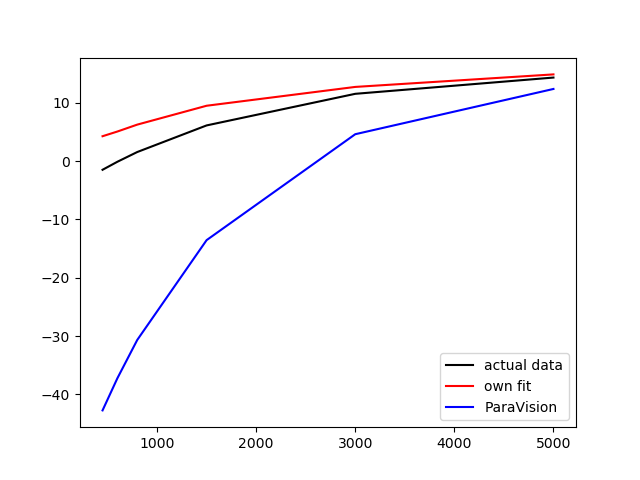

In [17]:
# T1 - fit debugging

# Best Parameters, qMRI:
A = 15.660
B = 22.05
T1 = 1795.35

# Best Parameters, ParaVision:
A_ = 15.107
B_ = 78.135
T1_ = 1495.78

# measurement data:
y=[14.84, 12.695, 9.47, 6.235, 5.055, 4.247]
TI = [5000,3000,1500,800,600,450]

plot1 = A - B * np.exp( -1*np.array(TI) / T1)
plot2 = A_ - B_ * np.exp( -1*np.array(TI) / T1_)

print('error own fit: ', np.sum((plot1-y)**2))
print('error PV6: ', np.sum((plot2-y)**2))
plt.plot(TI,plot1,'k', label='actual data')
plt.plot(TI,y,'r', label='own fit')
plt.plot(TI,plot2,'b', label='ParaVision')
plt.legend();

In [1]:
%%html
<img src="img/relaxationT1.png" style="height:500px">

### T1 mapping code

In [9]:
# currently will take care of creating new folder with scan name, e.g. X7P1,  
# read the inversion times from method file (from raw folder which should be on same level as anaylsis folder),
# create automask (needed for Tqmap script), and put calculation in same new subfolder.
# only inputs: analysisfolder and scanname


folder = '/mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis'
scan_name = 'X7P1.nii.gz'

scan = os.path.join(folder,scan_name)
scan_name_no_ext = os.path.splitext(os.path.splitext(scan_name)[0])[0]

outfolder = os.path.join(folder, scan_name_no_ext)

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

outT1 = os.path.join(outfolder,f'T1map_qMRI_{scan_name}')


# glob.glob(f"{folder[:-9]}/**/method")
methodfile = glob.glob(f"{folder[:-9]}/7/method")[0]


# times_str = b.find_method_regex(methodfile[0], '##\$MultiRepTime=\\( (\d)+ \\)\n(.+)', selection=2) #unnecessary, since I have special function get_recovery_times

times = b.get_sat_recovery_times(methodfile, as_str=False)
TIfile = os.path.join(outfolder, 'TItimes.csv')
np.savetxt(TIfile, times, fmt="%d", delimiter=",")

mask = os.path.join(outfolder, f'mask_{scan_name}')
g.runAFNI(f"3dAutomask -overwrite -apply_prefix {mask} -peels 2 -erode 0 {scan}[0]")  #trial and error, erode 1 didnt remove tissue fully

# g.runAFNI("3dcalc -a X51P1.nii.gz[$..0] -expr 'a' -prefix X51inverted.nii.gz")  # to flip time axis, i.e. darker images / shortest TI comes first.
# TIlist = os.path.join(folder,'TItimes_inv.txt')
## above does not seem to make any difference. formula can deal with it apparently


g.runAFNI(f'qMRI_fit -i {scan} -t {TIfile} -T1 -m {mask} -o {outT1}')
print('complete')

3dAutomask -overwrite -apply_prefix /mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis/X7P1/mask_X7P1.nii.gz -peels 2 -erode 0 /mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis/X7P1.nii.gz[0]
qMRI_fit -i /mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis/X7P1.nii.gz -t /mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis/X7P1/TItimes.csv -T1 -m /mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis/X7P1/mask_X7P1.nii.gz -o /mnt/c/Users/felix/Documents/MRDATA/20181127_083057_ZK_3RD_SC_SEV_20181127_196_1_1_Analysis/X7P1/T1map_qMRI_X7P1.nii.gz
complete


### T2 mapping 

In [ ]:
g.runAFNI(f'qMRI_fit -i {scan} -t {Echolist} -T2 -m {mask} -o {outT2}')

### ROI extraction

In [68]:
# Option1:  drawing the ROI with fsleyes

roiname = 'manualROI.nii.gz'
roi = os.path.join(folder,roiname)
output = 'roidata_manual.1D'
out = os.path.join(folder,output)

g.extractROI(roi, outT1, out)

ROI extracted to /mnt/c/Users/felix/Documents/MRDATA/20190116_141334_ZK_SCI_3RD_MILD_20190116_212_1_1/51/roidata.1D


array([0.68852, 0.69243])

In [22]:
# todo: Integrate this nb with Bruker_Folder_to_Nii


# from pathlib import Path
nii_file = '/mnt/c/Users/felix/Documents/MRDATA/20190306_125108_ZK_SCI_3RD_SHAM_20190228_221_1_2/11/X11_final.nii.gz'

nii_folder = '/mnt/c/Users/felix/Documents/MRDATA/20190306_125108_ZK_SCI_3RD_SHAM_20190228_221_1_2/11'

outfolder = '~/qc_singleSubj'

out1 = os.path.join(nii_folder,'E11_propsegresult.nii.gz')

# sct.run(['3dTcat' ,'-prefix', out1, nii_file])


# to test quickly in bash:
# sct_propseg -i /mnt/c/Users/felix/Documents/MRDATA/20190306_125108_ZK_SCI_3RD_SHAM_20190228_221_1_2/10/X10_singlepoint.nii.gz -c t2 -init-centerline viewer -rescale 10

# sct.run(['sct_deepseg_sc', '-i', nii_file, '-c', 't2', '-ofolder', outfolder, '-centerline', 'cnn', '-brain', '0', '-rescale', '10'])

sct.run(['sct_propseg', '-i', nii_file, '-ofolder', nii_folder, '-c', 't2', '-init-centerline', 'viewer', '-rescale', '10'], verbose=0)



(0,
 "Folder /mnt/c/Users/felix/Documents/MRDATA/20190306_125108_ZK_SCI_3RD_SHAM_20190228_221_1_2/11 has been created.\nQStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-felix'\nqt.qpa.xcb: QXcbConnection: XCB error: 145 (Unknown), sequence: 177, resource id: 0, major code: 139 (Unknown), minor code: 20\n\nCreate temporary folder (/tmp/sct-20190513103527.155407-label_vertebrae-v43gh7si)...\nposition of last click: (11.0, 68.82423187034529, 100.41467576791808)\nnow we have 1 points.\nposition of last click: (9.0, 68.00511927490754, 100.41467576791808)\nnow we have 2 points.\nposition of last click: (8.0, 67.73208174309497, 100.74232081911262)\nnow we have 3 points.\nposition of last click: (6.0, 65.8208190204069, 103.0358361774744)\nnow we have 4 points.\nposition of last click: (5.0, 64.7286688931566, 104.34641638225256)\nnow we have 5 points.\nposition of last click: (10.0, 68.5511943385327, 100.08703071672355)\nnow we have 6 points.\nposition of last click: (10.0, 

In [15]:
import nibabel as nib
import numpy as np

np.set_printoptions(precision=2, suppress=True)
file1 = '/home/felix/sct_training/sct_course-london19/single_subject/data/t2/t2.nii.gz'
img_human = nib.load(file1)
print(img_human.header)

file2 = '/mnt/c/Users/felix/Documents/MRDATA/20190306_125108_ZK_SCI_3RD_SHAM_20190228_221_1_2/10/X10P1.nii.gz'
img_rat = nib.load(file2)
print(img_rat.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [  3  64 320 320   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  0.8 0.8 0.8 1.5 0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=1.2e+02;Time=110001.045;phase=1'
aux_file        : b'imgComments'
qform_code      : scanner
sform_code      : scanner
quatern_b       : -2.4482096e-12
quatern_c       : -0.013089588
quatern_d       : -3.1958814e-14
qoffset_x       : -19.45205
qoffset_